In [95]:
import pandas as pd
import numpy as np
from scipy.stats import beta
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import permutations
from joblib import Parallel, delayed
from copy import copy

In [2]:
sns.set_style('white')

In [35]:
events = ['PA', '1B', '2B', '3B', 'HR', 'BB', 'K', 'HBP', 'SB']

In [47]:
df = pd.concat({n: pd.read_csv(f'results/{n}/offense.csv') for n in [2024, 2025]})

# Weight 2024 down, so it counts less.
# Lifting relative weighting used in ZiPS, which is probably decent here
for n in events:
    df.loc[2024, n] = (df.loc[2024, n] * 5/8).values

sum_df = df.groupby('Name')[['PA', '1B', '2B', '3B', 'HR', 'BB', 'K', 'HBP', 'SB']].sum()
rate_df = sum_df.divide(sum_df.PA, axis=0)

In [219]:
sums_df = sum_df.sum()
bh_rates = sums_df.loc['1B': '3B'] / sums_df.loc['1B': '3B'].sum()

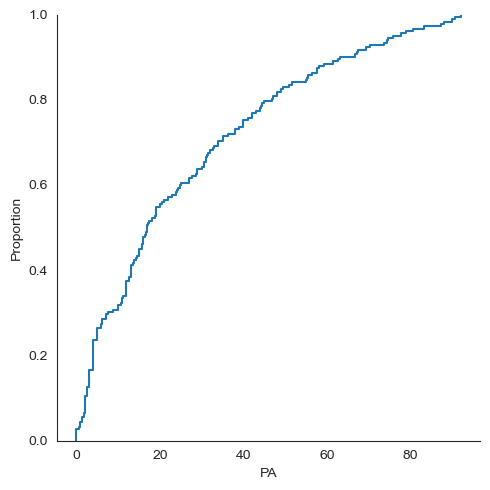

In [49]:
# Plot total weighted PA to get sense of reasonable cutoff
sns.displot(sum_df.PA, stat='proportion', kind='ecdf')

In [50]:
min_pa = 30
filtered_rate_df = rate_df.loc[sum_df['PA'] > min_pa]
sums_df = sum_df.loc[sum_df['PA'] > min_pa].sum()

In [51]:
# We initialize this now.
# These are going to be determined by playing around with the graphs below
# Our goal is to set initial hyperparameters where the beta distribution
# roughly matches the empirical distribution of rates

init_hyperparams = {}

In [71]:
def get_dist_plots(event, a):
    global filtered_rate_df
    global init_hyperparams


    fig, ax1 = plt.subplots()
    sns.histplot(filtered_rate_df[event], ax=ax1)

    x_low, x_hi = ax1.get_xbound()
    b = a / (sums_df[event] / sums_df['PA'])
    x = np.linspace(max(0,x_low), x_hi, 1000)
    print(a, b)

    init_hyperparams[event] = (float(a), b)


    ax2 = ax1.twinx()
    ax2.plot(x, beta.pdf(x, a, b), color='k', lw=3, scaley=True)
    ax2.set_ylim(0)
    return ax1

4 19.282868525896415


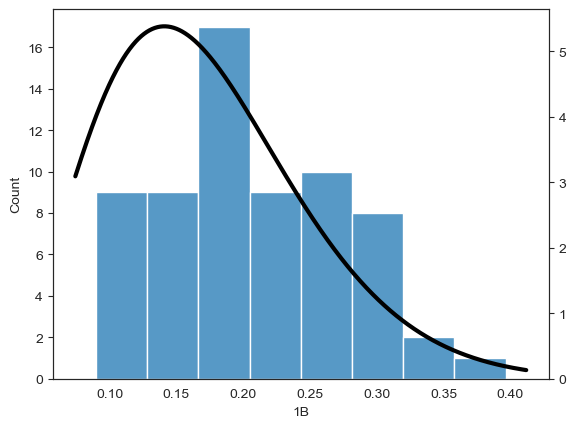

In [87]:
ax1 = get_dist_plots('1B', 4)

1.5 34.049755301794455


<Axes: xlabel='2B', ylabel='Count'>

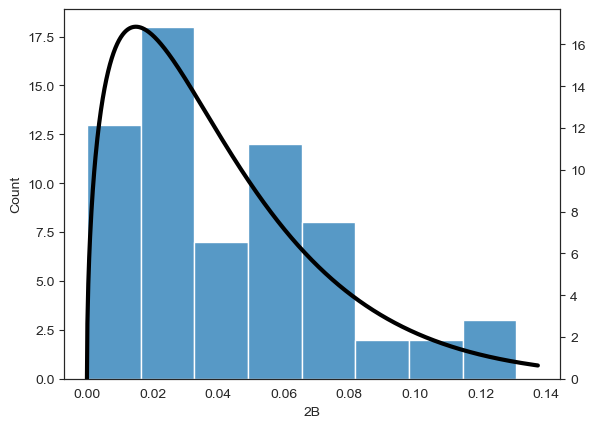

In [88]:
get_dist_plots('2B', 1.5)

0.5 132.52380952380952


<Axes: xlabel='3B', ylabel='Count'>

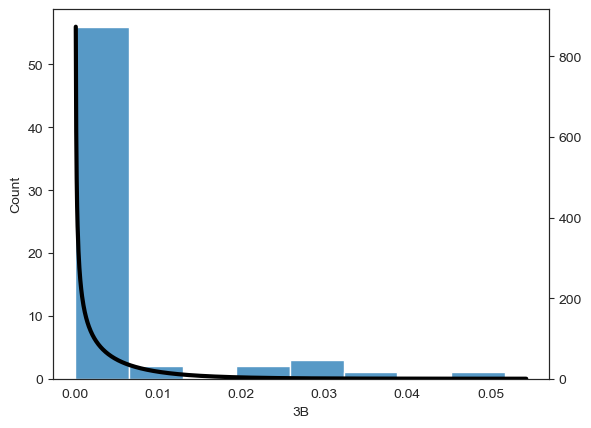

In [102]:
get_dist_plots('3B', 0.5)

0.5 38.333333333333336


<Axes: xlabel='HR', ylabel='Count'>

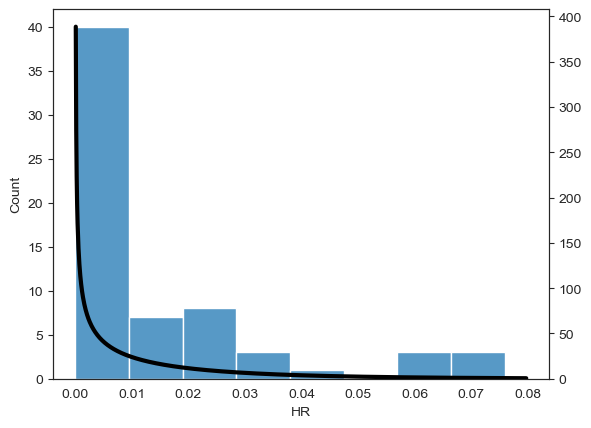

In [101]:
get_dist_plots('HR', 0.5)

3 29.9247311827957


<Axes: xlabel='BB', ylabel='Count'>

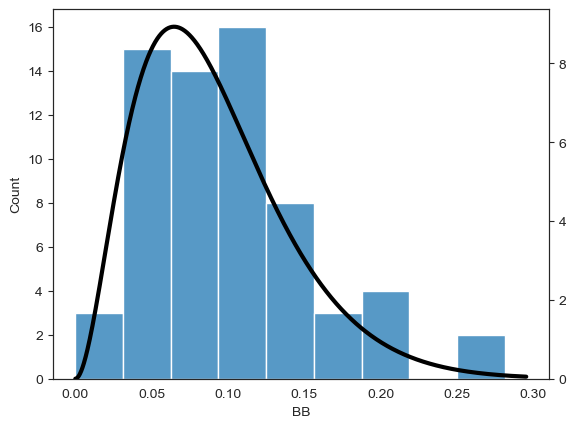

In [91]:
get_dist_plots('BB', 3)

1.5 52.77496839443742


<Axes: xlabel='HBP', ylabel='Count'>

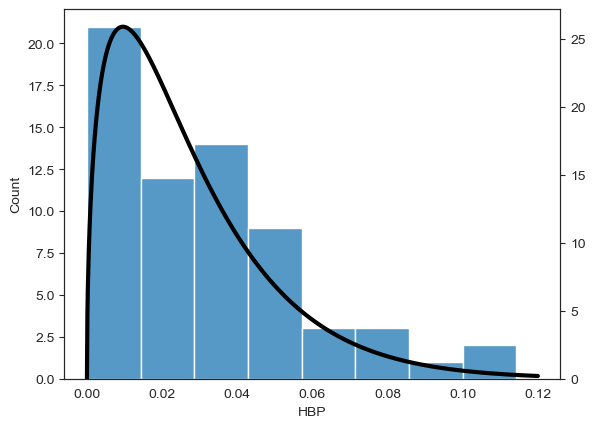

In [92]:
get_dist_plots('HBP', 1.5)

2 10.246686303387335


<Axes: xlabel='K', ylabel='Count'>

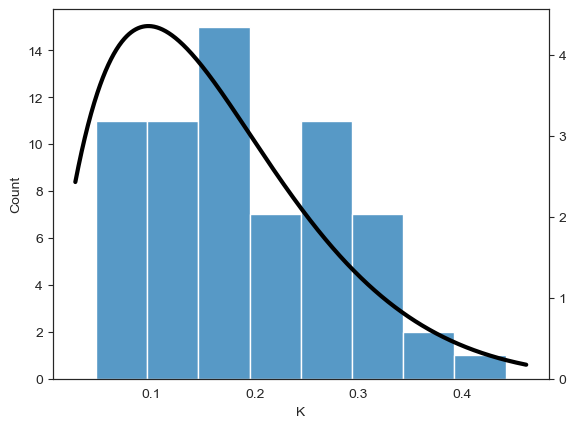

In [93]:
get_dist_plots('K', 2)

1 15.166212534059945


<Axes: xlabel='SB', ylabel='Count'>

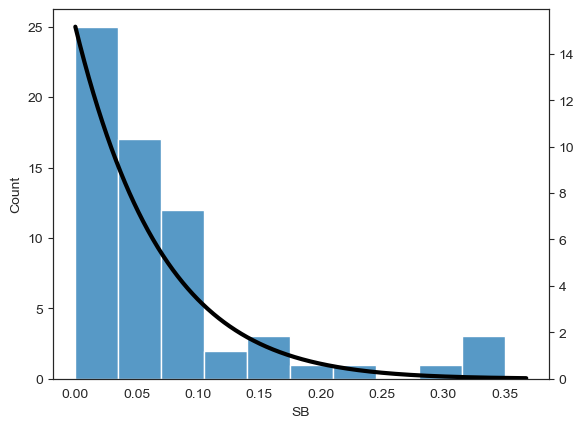

In [94]:
get_dist_plots('SB', 1)

In [103]:
init_hyperparams

{'1B': (4.0, np.float64(19.282868525896415)),
 '2B': (1.5, np.float64(34.049755301794455)),
 '3B': (0.5, np.float64(132.52380952380952)),
 'HR': (0.5, np.float64(38.333333333333336)),
 'BB': (3.0, np.float64(29.9247311827957)),
 'HBP': (1.5, np.float64(52.77496839443742)),
 'K': (2.0, np.float64(10.246686303387335)),
 'SB': (1.0, np.float64(15.166212534059945))}

In [81]:
# Only care about our team
l_df = df.set_index('Team', append=True).loc[(2025, slice(None), 'Legends')]

# Filtered on playoff_eligible pool
playoff_eligible = l_df.loc[l_df.GP >= 7, 'Name'].values

# get sums for playoff eligible players
lu_df = sum_df.loc[playoff_eligible]

playoff_eligible

array(['Cody Stevens', 'Kasim Hussain', 'Kellen Hatheway',
       'Steven Ferguson', 'Rico Pena', 'Derek Chance', 'Adam Tuszynski',
       'Matthew Polites', 'Andrew Gerety', 'Ryan Stevens',
       'Alexander Delk', 'Brian Holman', 'Jake Sahagian', 'Kyle Henke',
       'Christian LeClaire', 'Brett Klasko', 'Kyle Aube'], dtype=object)

In [82]:
lu_df

,PA,1B,2B,3B,HR,BB,K,HBP,SB
Name,,,,,,,,,
Cody Stevens,80.625,23.375,8.875,3.000,1.625,7.500,5.750,3.250,3.250
Kasim Hussain,61.375,9.625,4.875,0.000,2.000,11.500,16.250,2.000,2.000
Kellen Hatheway,66.750,16.625,3.500,1.875,3.875,4.250,17.375,2.250,5.250
Steven Ferguson,67.500,11.125,1.625,0.625,1.625,7.250,23.375,3.625,5.000
Rico Pena,32.000,6.000,1.000,0.000,0.000,9.000,8.000,1.000,1.000
Derek Chance,74.625,13.875,5.500,0.000,1.000,6.250,4.375,1.625,6.875
Adam Tuszynski,43.000,11.000,1.000,0.000,0.000,3.000,3.000,4.000,3.000
Matthew Polites,31.375,5.625,1.875,0.000,1.000,3.625,6.250,2.250,1.875
Andrew Gerety,56.500,11.625,7.125,0.000,0.000,4.500,7.125,0.000,8.500


In [86]:
init_hyperparams

{'1B': (np.float64(362.75), np.float64(-5038.592131474104)),
 '2B': (np.float64(94.75), np.float64(-100.07524469820555)),
 '3B': (np.float64(12.0), np.float64(1749.047619047619)),
 'HR': (np.float64(30.25), np.float64(1217.2916666666667)),
 'BB': (np.float64(204.5), np.float64(-2008.3252688172042)),
 'HBP': (np.float64(57.25), np.float64(700.8999683944375)),
 'K': (np.float64(383.5), np.float64(-4896.753313696612)),
 'SB': (np.float64(56.75), np.float64(680.2912125340599))}

In [116]:
class Player:
    def __init__(self, player_name):
        self.player_name = player_name
        self.hyperparams = copy(init_hyperparams)
        self.weights = {}

    def ab(self):
        return np.random.choice(list(self.weights.keys()), p=list(self.weights.values()))

    def update_hyperparams(self, results):
        pa = results.loc['PA']
        weights = {}
        for i in ['1B', '2B', '3B', 'HR', 'BB', 'K', 'HBP']:
            a, b = self.hyperparams[i]
            a += results.loc[i]
            b += (pa - a)
            self.hyperparams[i] = a, b
            self.weights[i] = beta.mean(a, b)

        nonk = 1 - np.sum(list(self.weights.values()))
        self.weights['OUT'] = nonk * .9
        self.weights['ERR'] = nonk * .1

        a, b = self.hyperparams['SB']
        a += results.loc['SB']
        b += (pa - a)
        self.hyperparams['SB'] = a, b
        self.weights['SB'] = beta.mean(a, b)

In [117]:
weights_df = lu_df.copy()
weights_df['OUT'] = np.nan
weights_df['ERR'] = np.nan
for n in playoff_eligible:
    player = Player(n)
    player.update_hyperparams(lu_df.loc[n])
    weights_df.loc[n] = pd.Series(player.weights, name=n)
weights_df.drop(columns=['PA'], inplace=True)
weights_df

,1B,2B,3B,HR,BB,K,HBP,SB,OUT,ERR
Name,,,,,,,,,,
Cody Stevens,0.274002,0.090473,0.016420,0.017863,0.094980,0.085285,0.035607,0.044367,0.346831,0.038537
Kasim Hussain,0.168923,0.066807,0.002579,0.025073,0.158818,0.254811,0.030661,0.039195,0.263095,0.029233
Kellen Hatheway,0.239734,0.049603,0.011918,0.041634,0.074994,0.251634,0.031374,0.076297,0.269198,0.029911
Steven Ferguson,0.174286,0.030773,0.005624,0.020079,0.105209,0.326380,0.042611,0.072581,0.265534,0.029504
Rico Pena,0.194997,0.037850,0.003039,0.007109,0.193784,0.236705,0.029490,0.042403,0.267324,0.029703
Derek Chance,0.190346,0.064412,0.002414,0.013279,0.088475,0.075113,0.024529,0.087703,0.487288,0.054143
Adam Tuszynski,0.240837,0.032447,0.002849,0.006148,0.082277,0.093903,0.057426,0.068768,0.435704,0.048412
Matthew Polites,0.190000,0.051586,0.003051,0.021518,0.108076,0.198214,0.044563,0.061773,0.344693,0.038299
Andrew Gerety,0.206181,0.095251,0.002645,0.005272,0.086781,0.136711,0.013727,0.132559,0.408088,0.045343


In [118]:
lw_df = pd.read_csv('data/guts/linear_weights.csv', index_col='outcome')
lw_df

,run_exp_change
outcome,
1B,0.973550
2B,1.320377
3B,1.433249
BB,0.866691
HBP,0.871860
HR,1.838045
wOBA_scale,0.871340
runSB,0.200000


In [149]:
bayes_woba = (weights_df['1B'] * lw_df.loc['1B', 'run_exp_change']
              + weights_df['2B'] * lw_df.loc['2B', 'run_exp_change']
              + weights_df['3B'] * lw_df.loc['3B', 'run_exp_change']
              + weights_df['HR'] * lw_df.loc['HR', 'run_exp_change']
              + weights_df['BB'] * lw_df.loc['BB', 'run_exp_change']
              + weights_df['HBP'] * lw_df.loc['HBP', 'run_exp_change']
              + weights_df['ERR'] * lw_df.loc['1B', 'run_exp_change']
              + weights_df['SB'] * lw_df.loc['runSB', 'run_exp_change']
              ).sort_values(ascending=False)

bayes_obp = (1 - weights_df['OUT'] - weights_df['K'])

bayes_df = pd.concat([bayes_woba, bayes_obp], axis=1, keys=['wOBA (Bayes)', 'OBP (Bayes)'])
bayes_df['SLG bias (Bayes)'] = bayes_df['wOBA (Bayes)'] / bayes_df['OBP (Bayes)'] - 1

<Axes: ylabel='Name'>

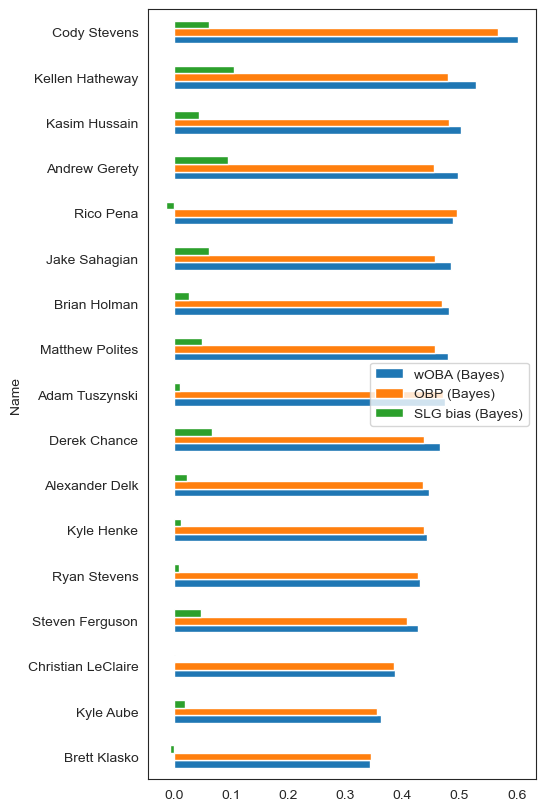

In [150]:
bayes_df.sort_values('wOBA (Bayes)').plot.barh(figsize=(5,10))

In [402]:
bayes_df.sort_values('wOBA (Bayes)', ascending=False).round(3)

,wOBA (Bayes),OBP (Bayes),SLG bias (Bayes)
Name,,,
Cody Stevens,0.602,0.568,0.061
Kellen Hatheway,0.529,0.479,0.104
Kasim Hussain,0.503,0.482,0.044
Andrew Gerety,0.498,0.455,0.094
Rico Pena,0.488,0.496,-0.015
Jake Sahagian,0.485,0.457,0.061
Brian Holman,0.481,0.469,0.026
Matthew Polites,0.479,0.457,0.048
Adam Tuszynski,0.475,0.470,0.010


In [307]:
class Lineup:
    def __init__(self, order: tuple, weights: pd.DataFrame):
        self.order = order
        self.length = len(order)
        self.index = 0
        self.weights = weights

    def __iter__(self):
        return self

    def __next__(self):
        if self.index == self.length:
            self.index = 0
        player = self.order[self.index]
        self.index += 1
        return np.random.choice(self.weights.columns, p=self.weights.loc[player])


class Game:
    def __init__(self, order: tuple, weights: pd.DataFrame):
        self.lineup = Lineup(order, weights)
        self.order = order
        self.weights = weights
        self.inning = 1
        self.outs = 0
        self.runs = 0
        self.first = False
        self.second = False
        self.third = False

    def __iter__(self):
        return self

    def __next__(self):
        return self.sim_game()

    def reset(self):
        self.lineup =Lineup(self.order, self.weights)
        self.inning = 1
        self.outs = 0
        self.runs = 0
        self.first = False
        self.second = False
        self.third = False

    def sim_game(self):
        while self.inning < 10:
            self.sim_inning()
            self.inning += 1
        runs_scored = self.runs
        self.reset()
        return runs_scored

    def sim_inning(self):
        self.first = False
        self.second = False
        self.third = False
        while self.outs < 3:
            result = next(self.lineup)
            r = np.random.rand()
            if result == 'ERR':
                result = rng.choice(bh_rates.index, p=bh_rates.values)
            if result == 'K':
                self.outs += 1
            elif result == 'OUT':
                if r > 0.25:
                    if self.third:
                        self.third = False
                        self.runs += 1
                if r > 0.15:
                    if self.second:
                        self.third = True
            elif result == '1B':
                if self.third:
                    self.third = False
                    self.runs += 1
                if self.second:
                    self.second = False
                    if r > 0.3:
                        self.runs += 1
                    elif r < 0.02:
                        self.outs += 1
                    else:
                        self.third = True
                if self.first:
                    if (~self.third) & (r > 0.5):
                        self.third = True
                    else:
                        self.second = True
                self.first = True
            elif result == '2B':
                if self.third:
                    self.third = False
                    self.runs += 1
                if self.second:
                    self.runs += 1
                if self.first:
                    self.first = False
                    if r > 0.3:
                        self.runs += 1
                    elif r < 0.01:
                        self.outs += 1
                    else:
                        self.third = True
                self.second = True
            elif result == '3B':
                self.runs += self.third + self.second + self.first
                self.third = True
                self.second = False
                self.first = False
            elif result == 'HR':
                self.runs += 1 + self.third + self.second + self.first
                self.first = False
                self.second = False
                self.third = False
            elif (result == 'BB') | (result == 'HBP'):
                if self.first:
                    if self.second:
                        if self.third:
                            self.runs += 1
                        self.third = True
                    self.second = True
                else:
                    self.first = True

In [314]:
def get_results(lineup, n_iter=1000):
    gen = Game(order=lineup, weights=weights_df.loc[list(lineup), [n for n in weights_df.columns if n != 'SB']])
    return [next(gen) for i in range(n_iter)]

In [142]:
out = ['Matthew Polites', 'Jake Sahagian', 'Andrew Gerety']
pitching = ['Kyle Henke']
lineup_pool = [n for n in playoff_eligible if n not in out if n not in pitching]

In [143]:
bayes_df.loc[bayes_df.index.isin(lineup_pool)]

,wOBA (Bayes),OBP (Bayes),SLG bias (Bayes)
Name,,,
Cody Stevens,0.602336,0.567883,0.034453
Kellen Hatheway,0.529224,0.479168,0.050056
Kasim Hussain,0.503123,0.482094,0.021030
Rico Pena,0.488298,0.495971,-0.007674
Brian Holman,0.480997,0.468877,0.012121
Adam Tuszynski,0.474951,0.470394,0.004558
Derek Chance,0.466545,0.437598,0.028947
Alexander Delk,0.445721,0.436032,0.009689
Ryan Stevens,0.430293,0.426709,0.003585


In [308]:
# My best guess at what Brett would do with this lineup pool in a must-win game
reg_lineup = (
    'Ryan Stevens',
    'Cody Stevens',
    'Alexander Delk',
    'Kellen Hatheway',
    'Rico Pena',
    'Steven Ferguson',
    'Derek Chance',
    'Brian Holman',
    'Adam Tuszynski'
)

# Traditional Lineup Construction (i.e. best hitter 3rd) based on Bayes statistics.
trad_lineup = (
    'Brian Holman', # Leadoff. Good Contact Guy. With Good/Decent Speed.
    'Rico Pena', # 2-hole best bat control
    'Cody Stevens', # 3-hole best overall hitter
    'Kellen Hatheway', # 4-hole Best power hitter
    'Kasim Hussain', # 5-hole 2nd best power hitter
    'Adam Tuszynski', # 6-9: The rest
    'Derek Chance',
    'Alexander Delk',
    'Ryan Stevens',
)

# Saber Lineup Construction.
sabr_lineup = (
    'Kasim Hussain', # Top-3 hitter with highest OBP Bias.
    'Cody Stevens', # Top-3 hitter with best Balance. Usually best overall.
    'Brian Holman', # 5th- best hitter
    'Kellen Hatheway', # Top-3 Hitter with highest SLG Bias
    'Rico Pena', # 4th-best hitter
    'Adam Tuszynski', #6-9: The rest.
    'Derek Chance',
    'Alexander Delk',
    'Ryan Stevens'
)

# Want to control for different lineup lengths too
trad10_lineup = trad_lineup + ('Steven Ferguson',)
sabr10_lineup = sabr_lineup + ('Steven Ferguson',)
reg9_lineup = (
    'Ryan Stevens',
    'Cody Stevens',
    'Alexander Delk',
    'Kellen Hatheway',
    'Rico Pena',
    'Derek Chance',
    'Brian Holman',
    'Adam Tuszynski'
)

In [309]:
rng = np.random.default_rng()

In [310]:
reg_results = get_results(reg_lineup, n_iter=100000)
trad_results = get_results(trad_lineup, n_iter=100000)
sabr_results = get_results(sabr_lineup, n_iter=100000)
trad10_results = get_results(trad10_lineup, n_iter=100000)
sabr10_results = get_results(sabr10_lineup, n_iter=100000)
reg9_results = get_results(reg9_lineup, n_iter=100000)

In [311]:
manual_pass_df = pd.DataFrame([reg9_results, trad_results, sabr_results, reg_results, trad10_results, sabr10_results], index=['regular 9', 'traditional 9', 'saber 9', 'regular 10', 'traditional 10', 'saber 10']).T
manual_pass_df = manual_pass_df.stack().reset_index(level=0, drop=True).reset_index()
manual_pass_df['lineup'] = manual_pass_df['index'].str.split(' ').str[0]
manual_pass_df['len'] = manual_pass_df['index'].str.split(' ').str[-1]
manual_pass_df.rename(columns={0: 'runs'}, inplace=True)

<Axes: xlabel='lineup', ylabel='runs'>

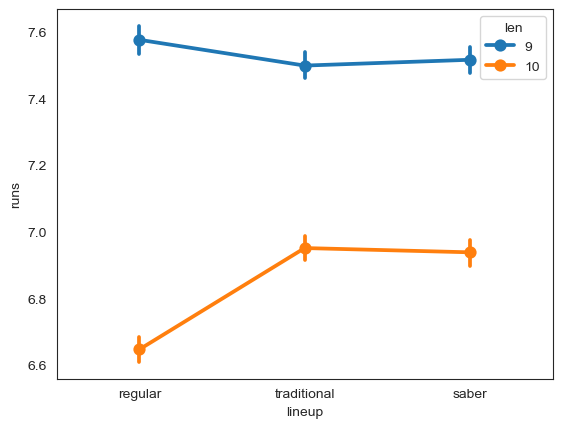

In [312]:
sns.pointplot(manual_pass_df, x='lineup', y='runs', hue='len')

In [240]:
# Hell yeah we're going to brute force every permutation with these 9 players.
starting_perms = [n for n in permutations(bayes_df.loc[bayes_df.index.isin(lineup_pool)].index[:9])]
len(starting_perms)

362880

In [315]:
results = Parallel(n_jobs=12, verbose=1)(delayed(get_results)(n, n_iter=2000) for n in starting_perms)

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    5.4s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:   24.7s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:   59.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:  1.7min
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:  2.6min
[Parallel(n_jobs=12)]: Done 1776 tasks      | elapsed:  3.7min
[Parallel(n_jobs=12)]: Done 2426 tasks      | elapsed:  5.0min
[Parallel(n_jobs=12)]: Done 3176 tasks      | elapsed:  6.6min
[Parallel(n_jobs=12)]: Done 4026 tasks      | elapsed:  8.3min
[Parallel(n_jobs=12)]: Done 4976 tasks      | elapsed: 10.2min
[Parallel(n_jobs=12)]: Done 6026 tasks      | elapsed: 12.3min
[Parallel(n_jobs=12)]: Done 7176 tasks      | elapsed: 14.7min
[Parallel(n_jobs=12)]: Done 8426 tasks      | elapsed: 17.2min
[Parallel(n_jobs=12)]: Done 9776 tasks      | elapsed: 20.0min
[Parallel(n_jobs=12)]: Done 11226 tasks      

In [316]:
def parse_results(results):
    df = pd.DataFrame(results).T
    rm_df = df.mean().rename('runs_mean').to_frame()
    rm_df['std_mean'] = df.std() / np.sqrt(1000)
    rm_df['ci_low'] = rm_df['runs_mean'] - 1.96 * rm_df['std_mean']
    rm_df['ci_high'] = rm_df['runs_mean'] + 1.96 * rm_df['std_mean']
    return rm_df

In [317]:
rm_df = parse_results(results)

In [327]:
best_rands = rm_df.loc[rm_df['runs_mean'] > rm_df['ci_low'].max()].index
len(best_rands)

1458

In [320]:
final_lineup_opt_results = Parallel(n_jobs=12, verbose=1)(delayed(get_results)(starting_perms[i], n_iter=50000) for i in best_rands)

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:  1.7min
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  8.5min
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed: 20.5min
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed: 37.0min
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed: 58.6min
[Parallel(n_jobs=12)]: Done 1458 out of 1458 | elapsed: 69.6min finished


In [326]:
final_df = parse_results(final_lineup_opt_results)
final_df = final_df.loc[final_df.runs_mean > final_df.ci_low.max()].copy()
len(final_df)

1417

In [323]:
final_df.sort_values('runs_mean', ascending=False, inplace=True)
final_df.head()

,runs_mean,std_mean,ci_low,ci_high
1207,8.01676,0.207042,7.610958,8.422562
297,7.99356,0.206395,7.589026,8.398094
1226,7.98890,0.205906,7.585324,8.392476
909,7.98604,0.207085,7.580153,8.391927
326,7.98414,0.206785,7.578841,8.389439


<Axes: xlabel='runs_mean', ylabel='Count'>

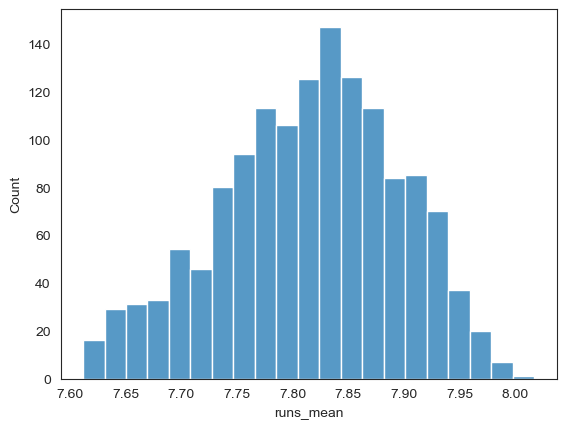

In [347]:
sns.histplot(final_df.runs_mean)

In [348]:
pos_df = pd.DataFrame([starting_perms[best_rands[n]] + (final_df.loc[n, 'runs_mean'], ) for n in final_df.loc[final_df.runs_mean > 7.9].index], columns=[n for n in range(1, 10)] + ['runs'])
pos_df.head()

,1,2,3,4,5,6,7,8,9,runs
0,Cody Stevens,Rico Pena,Adam Tuszynski,Derek Chance,Brian Holman,Kellen Hatheway,Kasim Hussain,Alexander Delk,Ryan Stevens,7.92206
1,Cody Stevens,Rico Pena,Derek Chance,Adam Tuszynski,Brian Holman,Kellen Hatheway,Alexander Delk,Kasim Hussain,Ryan Stevens,7.90210
2,Cody Stevens,Brian Holman,Rico Pena,Adam Tuszynski,Derek Chance,Alexander Delk,Kellen Hatheway,Kasim Hussain,Ryan Stevens,7.90438
3,Cody Stevens,Brian Holman,Adam Tuszynski,Rico Pena,Derek Chance,Kellen Hatheway,Kasim Hussain,Alexander Delk,Ryan Stevens,7.93024
4,Cody Stevens,Brian Holman,Adam Tuszynski,Derek Chance,Kasim Hussain,Alexander Delk,Rico Pena,Ryan Stevens,Kellen Hatheway,7.93850


In [372]:
pos_df.groupby(1).runs.agg(['sum' ,'mean']).sort_values('sum', ascending=False)

,sum,mean
1,,
Cody Stevens,1015.09360,7.930419
Adam Tuszynski,404.22460,7.925973
Derek Chance,396.52572,7.930514


In [373]:
pos_df.groupby(2).runs.agg(['sum' ,'mean']).sort_values('sum', ascending=False)

,sum,mean
2,,
Cody Stevens,666.03928,7.929039
Derek Chance,578.97028,7.931100
Adam Tuszynski,499.57272,7.929726
Brian Holman,47.53412,7.922353
Rico Pena,15.82416,7.912080
Alexander Delk,7.90336,7.903360


In [375]:
pos_df.groupby(3).runs.agg(['sum' ,'mean']).sort_values('sum', ascending=False)

,sum,mean
3,,
Adam Tuszynski,634.56626,7.932078
Derek Chance,555.08866,7.929838
Brian Holman,214.05974,7.928139
Rico Pena,206.13320,7.928200
Cody Stevens,134.71104,7.924179
Kasim Hussain,47.50694,7.917823
Alexander Delk,15.87264,7.936320
Kellen Hatheway,7.90544,7.905440


In [376]:
pos_df.groupby(4).runs.agg(['sum' ,'mean']).sort_values('sum', ascending=False)

,sum,mean
4,,
Brian Holman,484.01258,7.934632
Rico Pena,341.11734,7.932961
Derek Chance,229.81438,7.924634
Adam Tuszynski,214.12098,7.930407
Alexander Delk,206.01226,7.923548
Kellen Hatheway,174.35756,7.925344
Kasim Hussain,166.40882,7.924230


In [377]:
pos_df.groupby(5).runs.agg(['sum' ,'mean']).sort_values('sum', ascending=False)

,sum,mean
5,,
Brian Holman,523.31146,7.928962
Rico Pena,317.30210,7.932552
Alexander Delk,309.48550,7.935526
Kasim Hussain,277.49108,7.928317
Kellen Hatheway,253.62398,7.925749
Adam Tuszynski,63.35936,7.919920
Derek Chance,55.44488,7.920697
Ryan Stevens,15.82556,7.912780


In [378]:
pos_df.groupby(6).runs.agg(['sum' ,'mean']).sort_values('sum', ascending=False)

,sum,mean
6,,
Alexander Delk,460.06384,7.932135
Kellen Hatheway,404.44610,7.930316
Kasim Hussain,316.98556,7.924639
Rico Pena,309.35310,7.932131
Brian Holman,293.37468,7.929045
Ryan Stevens,31.62064,7.905160


In [379]:
pos_df.groupby(7).runs.agg(['sum' ,'mean']).sort_values('sum', ascending=False)

,sum,mean
7,,
Kellen Hatheway,452.37368,7.936380
Kasim Hussain,396.68830,7.933766
Alexander Delk,380.43246,7.925676
Rico Pena,261.62074,7.927901
Ryan Stevens,174.20370,7.918350
Brian Holman,150.52504,7.922371


In [380]:
pos_df.groupby(8).runs.agg(['sum' ,'mean']).sort_values('sum', ascending=False)

,sum,mean
8,,
Ryan Stevens,491.37632,7.925425
Kasim Hussain,404.66222,7.934553
Kellen Hatheway,340.95828,7.929262
Alexander Delk,285.55838,7.932177
Rico Pena,198.19094,7.927638
Brian Holman,95.09778,7.924815


In [381]:
pos_df.groupby(9).runs.agg(['sum' ,'mean']).sort_values('sum', ascending=False)

,sum,mean
9,,
Ryan Stevens,1102.81770,7.933940
Kasim Hussain,206.10100,7.926962
Kellen Hatheway,182.17888,7.920821
Rico Pena,166.30234,7.919159
Alexander Delk,150.51548,7.921867
Brian Holman,7.92852,7.928520


In [387]:
np.argsort()[::-1]

array([8, 0, 1, 2, 4, 7, 3, 5, 6])

In [389]:
lineup = ['blank' for n in range(9)]
effect_sizes = [pos_df.groupby(n).runs.sum().max() for n in range(1, 10)]
for n in np.argsort(effect_sizes)[::-1]:
    counts = pos_df.groupby(n+1).runs.sum().sort_values(ascending=False)
    lineup[n] = counts.loc[~counts.index.isin(lineup)].index[0]
lineup

['Cody Stevens',
 'Derek Chance',
 'Adam Tuszynski',
 'Rico Pena',
 'Brian Holman',
 'Alexander Delk',
 'Kellen Hatheway',
 'Kasim Hussain',
 'Ryan Stevens']

In [395]:
opt_results = get_results(tuple(lineup), n_iter=100000)

In [398]:
opt10_results = get_results(tuple(lineup + ['Steven Ferguson']), n_iter=100000)

In [399]:
manual_pass_df = pd.DataFrame([reg9_results, trad_results, sabr_results, reg_results, trad10_results, sabr10_results, opt_results, opt10_results],
                              index=['regular 9', 'traditional 9', 'saber 9', 'regular 10', 'traditional 10', 'saber 10', 'optimized 9', 'optimized 10']).T
manual_pass_df = manual_pass_df.stack().reset_index(level=0, drop=True).reset_index()
manual_pass_df['lineup'] = manual_pass_df['index'].str.split(' ').str[0]
manual_pass_df['len'] = manual_pass_df['index'].str.split(' ').str[-1]
manual_pass_df.rename(columns={0: 'runs'}, inplace=True)

<Axes: xlabel='lineup', ylabel='runs'>

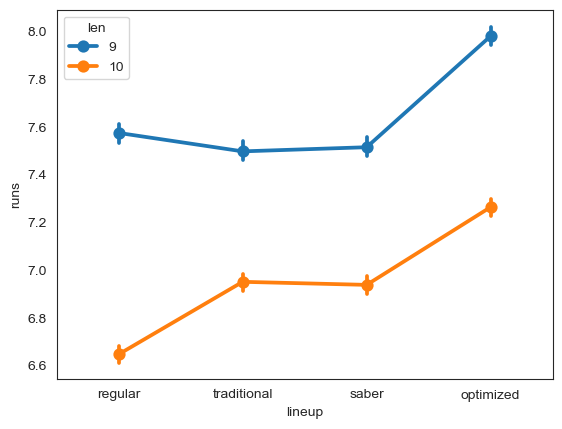

In [400]:
sns.pointplot(manual_pass_df, x='lineup', y='runs', hue='len')